In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive

import torch
import torch.nn as nn

%matplotlib tk

In [5]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])

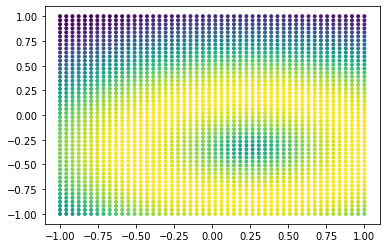

In [6]:
%matplotlib inline
plt.scatter(X1, X2, marker='.', c=Y)

## Create NN

In [7]:
torch.manual_seed(77733)

net = nn.Sequential(
        nn.utils.spectral_norm(nn.Linear(2,5)),
        nn.LeakyReLU(0.1),
        nn.utils.spectral_norm(nn.Linear(5,2))
)

In [8]:
## Spectral Normalize
for i in range(20):
    with torch.no_grad():
        yout = net(xx)+xx

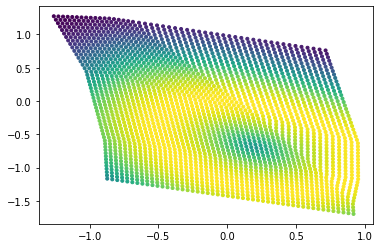

In [9]:
## this is for sure invertible.
# with torch.no_grad():
#     yout = net(xx)+xx

%matplotlib inline
y1, y2 = yout[:,0].numpy().reshape(X1.shape), yout[:,1].numpy().reshape(X1.shape)
plt.scatter(y1, y2, marker='.', c=Y)

In [10]:
nn.utils.remove_spectral_norm(net[0])
nn.utils.remove_spectral_norm(net[2])

Linear(in_features=5, out_features=2, bias=True)

## Rough

In [11]:
## this is constant 
W = torch.eye(2)
# W = torch.svd(torch.randn(2,2))[0]
W

tensor([[1., 0.],
        [0., 1.]])

In [12]:
z1 = net[0](xx)
a1 = net[1](z1)
yout = net[2](a1) + torch.matmul(xx, W)
yout = yout.data

In [13]:
mask = (a1>0).type(torch.float32)*0.9+0.1 ##_for leaky_relu
We = torch.matmul(net[0].weight.data.t(), mask.reshape(-1,5,1)*net[2].weight.data.t())      

In [14]:
We = torch.matmul(net[0].weight.data.t(), mask.reshape(-1,5,1)*net[2].weight.data.t())      

In [15]:
dets = torch.det(We+W)
(dets>0).type(torch.float32).sum()

tensor(2500.)

In [16]:
dets

tensor([1.0654, 1.0654, 1.0654,  ..., 1.2843, 1.2843, 1.2843])

## interactive plot

In [17]:
%matplotlib inline

ws = net[2].weight.data.t()
colors = np.array(['r', 'b'])

proj, We, yout = None, None, None
detW = torch.det(W)
dets = None
def network(w00 = ws[0,0], w01 = ws[0,1], 
            w10 = ws[1,0], w11 = ws[1,1], 
            w20 = ws[2,0], w21 = ws[2,1], 
            w30 = ws[3,0], w31 = ws[3,1], 
            w40 = ws[4,0], w41 = ws[4,1]):
    
    global proj, We, yout, dets
    
    w2 = torch.Tensor([w00, w01, w10, w11, w20, w21, w30, w31, w40, w41]).reshape(-1,2).t()
    net[2].weight.data = w2
    
#     for i in range(20):
    with torch.no_grad():
        z1 = net[0](xx)
        a1 = net[1](z1)
        yout = net[2](a1) + torch.matmul(xx, W)
        
        mask = (a1>0).type(torch.float32)*0.9+0.1 ##_for leaky_relu
        We = torch.matmul(net[0].weight.data.t(), mask.reshape(-1,5,1)*net[2].weight.data.t())      
        dets = torch.det(We+W)*torch.sign(detW)
        nofold = (dets>0).type(torch.int)
        fc = colors[nofold]    
    
    y1, y2 = yout[:,0].numpy().reshape(X1.shape), yout[:,1].numpy().reshape(X1.shape)
    plt.figure(figsize=(7*2,7*2))
    plt.scatter(y1, y2, c=fc, marker='.')
    plt.plot(y1, y2, lw=0.5)
    plt.plot(y1.T, y2.T, c='k', lw=0.5)
    
    plt.savefig('noinv_3.svg')
    
    print(f'Invertible: {nofold.sum()==2500}, min_det: {dets.min()}, {dets.argmin()}')

    
    
interactive_plot = interactive(network,
                               w00=(-3.,3.), w01=(-3.,3.),
                               w10=(-3.,3.), w11=(-3.,3.),
                               w20=(-3.,3.), w21=(-3.,3.),
                               w30=(-3.,3.), w31=(-3.,3.),
                               w40=(-3.,3.), w41=(-3.,3.)
                              )
interactive_plot ##_change w30;

interactive(children=(FloatSlider(value=-0.5607190728187561, description='w00', max=3.0, min=-3.0), FloatSlide…

In [119]:
# torch.save({'net':net.state_dict()}, "./00.2_net_state_dict.pt")

In [18]:
i = 1333
i = dets.argmin()
i

tensor(1333)

In [19]:
torch.svd(We[i]+W)

torch.return_types.svd(U=tensor([[-0.1848,  0.9828],
        [ 0.9828,  0.1848]]), S=tensor([1.3530, 0.0042]), V=tensor([[-0.1148, -0.9934],
        [ 0.9934, -0.1148]]))

In [20]:
torch.det(We[i]+W)#*torch.sign(torch.det(W))

tensor(-0.0057)

In [21]:
# torch.det(W.t())
torch.det((We[i]+W).t())
# torch.svd((We[i]+W).t())

tensor(-0.0057)

In [22]:
torch.det(W)

tensor(1.)

In [23]:
We[i]

tensor([[-0.9754, -0.2489],
        [-0.1535,  0.3208]])

In [24]:
torch.det(We[i])

tensor(-0.3511)

In [25]:
torch.det(We[i]-W)

tensor(1.3035)

In [26]:
# (We[i]+W).reshape(2,1,2)@W.reshape(2,2,1)
We[i]+W

tensor([[ 0.0246, -0.2489],
        [-0.1535,  1.3208]])

In [27]:
Wf = (We[i]+W).t()
Wfn = torch.norm(Wf, dim=0, keepdim=True)
Wfn

tensor([[0.2501, 1.3297]])

### overall matrix without relu

In [28]:
W12 = torch.matmul(net[0].weight.data.t(), net[2].weight.data.t()) 
W12

tensor([[-0.9282, -0.2638],
        [ 0.0567,  0.2544]])

In [29]:
torch.det(W12+W)*torch.sign(torch.det(W))

tensor(0.1051)

In [30]:
K = torch.svd(W12)[1].max() ## K-Lipschitz
K

tensor(0.9733)

In [31]:
#We need overall function to be K<1

### the determinant is negative if there is fold when going from initial basis to transformed points.

#### is this statement true ?? is there flip when there is rotation ??

Maybe. But linear interpolation between basis and transformed point is not true.


In [32]:
We.shape

torch.Size([2500, 2, 2])

In [33]:
A = torch.randn(4,4)
A

tensor([[ 0.3045,  0.2819,  1.1838,  0.9875],
        [ 1.5285, -0.4121, -0.5926,  0.2702],
        [ 0.4132,  1.4522,  0.5304,  0.5402],
        [ 0.7002,  0.9449,  1.4279,  0.2995]])

In [34]:
torch.det(A)

tensor(-2.8077)

In [35]:
### change signs of columns of transformation

B = A*1
B[:,0] *= -0.1
B[:,1] *= -1
torch.det(B)

tensor(-0.2808)

In [36]:
### change signs of rows of transformation

B = A*1
B[0] *= -0.1
B[1] *= -1
torch.det(B)

tensor(-0.2808)

In [37]:
### swap columns

In [39]:
# dets
# for i in range(0, 1, step=1/1000):
#     M = A*i+(1-i)*B
nsample = 1000
i = torch.linspace(0,1, nsample).reshape(-1,1,1)
dets = torch.det(B*i+A*(1-i))
torch.count_nonzero(dets<0)

tensor(591)

In [40]:
dets

tensor([-2.8077e+00, -2.7990e+00, -2.7903e+00, -2.7817e+00, -2.7730e+00,
        -2.7643e+00, -2.7557e+00, -2.7471e+00, -2.7384e+00, -2.7298e+00,
        -2.7212e+00, -2.7126e+00, -2.7041e+00, -2.6955e+00, -2.6870e+00,
        -2.6784e+00, -2.6699e+00, -2.6614e+00, -2.6529e+00, -2.6444e+00,
        -2.6360e+00, -2.6275e+00, -2.6191e+00, -2.6106e+00, -2.6022e+00,
        -2.5938e+00, -2.5854e+00, -2.5770e+00, -2.5686e+00, -2.5603e+00,
        -2.5519e+00, -2.5436e+00, -2.5353e+00, -2.5270e+00, -2.5187e+00,
        -2.5104e+00, -2.5021e+00, -2.4938e+00, -2.4856e+00, -2.4774e+00,
        -2.4691e+00, -2.4609e+00, -2.4527e+00, -2.4445e+00, -2.4364e+00,
        -2.4282e+00, -2.4200e+00, -2.4119e+00, -2.4038e+00, -2.3957e+00,
        -2.3876e+00, -2.3795e+00, -2.3714e+00, -2.3633e+00, -2.3553e+00,
        -2.3473e+00, -2.3392e+00, -2.3312e+00, -2.3232e+00, -2.3152e+00,
        -2.3073e+00, -2.2993e+00, -2.2913e+00, -2.2834e+00, -2.2755e+00,
        -2.2676e+00, -2.2597e+00, -2.2518e+00, -2.2

In [87]:
A = torch.eye(2)

B = torch.Tensor([[-0.1,0],
                  [0.1,-1]])
# print(torch.norm(B, dim=0, keepdim=True))
B = B/torch.norm(B, dim=0, keepdim=True)

# B = torch.sign(torch.randn(2,2))
# print(B)
# print(torch.det(B))

print(torch.det(A), torch.det(B))
i = torch.linspace(0,1, 100000).reshape(-1,1,1)
M = B*i+A*(1-i)
dets = torch.det(M)*torch.sign(torch.det(B))
torch.count_nonzero(dets<0)

tensor(1.) tensor(0.7071)


tensor(8579)

In [88]:
dets

tensor([1.0000, 1.0000, 0.9999,  ..., 0.7070, 0.7071, 0.7071])

In [89]:
## determinant of transpose is same
A = torch.randn(1000000,5,5)
da = torch.det(A)
dat = torch.det(A.transpose(1,2))
print(torch.count_nonzero(da*dat<0))
print(torch.count_nonzero(torch.abs(da-dat)>1e-4))
# del A

tensor(0)
tensor(0)


In [1]:
# torch.det(A)

In [2]:
# torch.det(A.transpose(1,2))

## Test on eigenvalues

The eigenvalues of the transformation must be all positive ???

In [105]:
A = torch.randn(1000,5,5)
da = torch.det(A)
torch.symeig(A)[0]

tensor([[-3.3834,  0.6105,  0.9366,  2.2046,  3.4462],
        [-4.0165, -0.8246, -0.0343,  1.4000,  1.9707],
        [-2.5218, -1.3587,  0.6905,  0.8086,  3.2928],
        ...,
        [-2.7214, -2.2774,  0.7608,  2.1822,  4.5361],
        [-3.0430, -1.5945,  1.1653,  1.8159,  3.5001],
        [-3.6186, -1.9369, -0.1781,  1.9837,  2.4292]])

In [106]:
torch.sign(da)

tensor([ 1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,
         1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,
         1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
         1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
        -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
         1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
        -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
         1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
         1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,
         1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,
         1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1.,  1.,
         1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1., -

### property of determinant

In [121]:
A = torch.randn(4,4)
A

tensor([[ 0.8546, -0.3535,  1.4998,  0.5904],
        [-0.0223, -1.6754,  0.1801,  0.2385],
        [-1.5305,  0.3961, -1.6956, -0.0345],
        [ 0.8508,  0.8314,  0.1362, -0.8794]])

In [122]:
D = torch.svd(A)[1]
print(D)
torch.det(A)

tensor([2.9845, 2.0568, 0.8914, 0.0130])


tensor(0.0709)

In [126]:
B = A*1
B[:,0] *= -1
B[:,1] *= -1
torch.det(B)

tensor(0.0709)

tensor([[ 1.8628, -0.4044,  0.9229,  0.5836],
        [-0.2052, -1.1970,  0.2918,  0.5571],
        [ 2.5142, -0.8513,  2.0884,  0.8722],
        [ 0.2207, -0.0610, -0.3320,  0.0079]])

In [109]:
B = torch.randn(200,200)

In [110]:
%timeit torch.det(B)

71.8 ms ± 5.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [111]:
%timeit torch.svd(B)

2.09 s ± 42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [112]:
%timeit torch.inverse(B)

182 ms ± 7.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
%timeit torch.matmul(B, B)

167 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### test determinant in 3d and nd

In [492]:
torch.manual_seed(77733)

nd = 4
nl = 4
layers = []
for i in range(0, nl-1):
    layers.append(nn.utils.spectral_norm(nn.Linear(nd,nd)))
    layers.append(nn.LeakyReLU(0.01))
# layers.append(nn.utils.spectral_norm(nn.Linear(nd,nd)))
layers.append(nn.Linear(nd,nd))


net2 = nn.Sequential(*layers)
net2

Sequential(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=4, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=4, bias=True)
)

In [493]:
xx2 = torch.rand(1000*100, nd)

In [494]:
## Spectral Normalize
# for i in range(1):
#     with torch.no_grad():
#         yout = net2(xx2)+xx2

for i in range(1):
    for i in range(0, nl-2):
        res = net2[i](res)

In [495]:
for i in range(0, nl):
    if i%2 == 0:
        nn.utils.remove_spectral_norm(net2[i])

In [496]:
# W = torch.eye(nd)

W = torch.randn(nd, nd)
# W = W/torch.norm(W, dim=0, keepdim=True)
W = torch.svd(W)[0]

In [497]:
# torch.det(W)
W

tensor([[-0.4796,  0.3916, -0.4699,  0.6291],
        [-0.1735,  0.8341,  0.2797, -0.4426],
        [-0.0376, -0.0541, -0.8018, -0.5939],
        [-0.8593, -0.3846,  0.2408, -0.2358]])

In [498]:
torch.norm(W, dim=0, keepdim=True), torch.det(W)

(tensor([[1.0000, 1.0000, 1.0000, 1.0000]]), tensor(-1.0000))

In [499]:
torch.norm(W, dim=1, keepdim=True), torch.det(W)

(tensor([[1.0000],
         [1.0000],
         [1.0000],
         [1.0000]]), tensor(-1.0000))

In [500]:
with torch.no_grad():
    res = net2[0](xx2)
    We = torch.unsqueeze(net2[0].weight.data.t(), dim=0)
    for i in range(1, nl):
        if i%2 == 0:
            mask = (res>0).type(torch.float32)*0.99+0.01
            _a = mask.shape[1]
            We = torch.matmul(We, mask.reshape(-1,_a,1)*net2[i].weight.data.t())
        res = net2[i](res)
    yout = res + torch.matmul(xx2, W)

In [501]:
detW = torch.det(W)
print(detW)
dets = torch.det(We+W)*torch.sign(detW)

tensor(-1.0000)


In [502]:
torch.count_nonzero(dets < 0)

tensor(0)

In [503]:
lips = torch.svd(We)[1].max(dim=1)[0]
torch.count_nonzero(lips > 1)

tensor(100000)

In [504]:
lips = torch.svd(We+W)[1].max(dim=1)[0]
torch.count_nonzero(lips > 1)

tensor(100000)

In [505]:
# torch.det(We)

In [506]:
lips = torch.svd((We+W)[:1000])[1].max(dim=1)[0]
torch.count_nonzero(lips > 1)

tensor(1000)

In [507]:
lips

tensor([2.1670, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 1.6509, 3.0878, 2.2638,
        3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878,
        3.0878, 2.2638, 3.0878, 2.1670, 3.0878, 2.2638, 3.0878, 3.0878, 3.0878,
        3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878,
        3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878,
        3.0878, 3.0878, 2.2638, 1.6509, 3.0878, 3.0878, 3.0878, 2.1670, 2.2638,
        3.0878, 3.0878, 3.0878, 2.1670, 3.0878, 3.0878, 3.0878, 2.2638, 3.0878,
        3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878,
        1.6509, 3.0878, 3.0878, 1.6509, 3.0878, 3.0878, 3.0878, 3.0878, 1.6509,
        1.6509, 3.0878, 2.1670, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878,
        3.0878, 2.2638, 2.1670, 3.0878, 3.0878, 1.6509, 3.0878, 3.0878, 3.0878,
        3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878, 3.0878,
        2.1670, 3.0878, 3.0878, 1.6509, 

In [508]:
dets[:1000]

tensor([2.0030, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 1.0447, 0.3111, 0.1780,
        0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111,
        0.3111, 0.1780, 0.3111, 2.0030, 0.3111, 0.1780, 0.3111, 0.3111, 0.3111,
        0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111,
        0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111,
        0.3111, 0.3111, 0.1780, 1.0447, 0.3111, 0.3111, 0.3111, 2.0030, 0.1780,
        0.3111, 0.3111, 0.3111, 2.0030, 0.3111, 0.3111, 0.3111, 0.1780, 0.3111,
        0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111,
        1.0447, 0.3111, 0.3111, 1.0447, 0.3111, 0.3111, 0.3111, 0.3111, 1.0447,
        1.0447, 0.3111, 2.0030, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111,
        0.3111, 0.1780, 2.0030, 0.3111, 0.3111, 1.0447, 0.3111, 0.3111, 0.3111,
        0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111, 0.3111,
        2.0030, 0.3111, 0.3111, 1.0447, 

## Is sign of determinant enough ?

does sign convey the idea that there is a fold while transforming basis vector to target vectors ??

If it does, then our method of det(We)*det(W_ref) is enough condition for invertibility.